# Import Modules

In [21]:
import pandas as pd
import numpy as np
import scipy
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import tree
from IPython.display import Image
import itertools
import pydotplus
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn import ensemble
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
warnings.filterwarnings('ignore')

# link to the dataset - https://www.kaggle.com/datasets/julianoorlandi/spotify-top-songs-and-audio-features
spotify_df_og = pd.read_csv('/content/drive/MyDrive/spotify_top_songs_audio_features.csv')

spotify_df_og.info()
# spotify_df.describe()
# spotify_df_og.nunique()

### The research question is whether it is possible to predict number of streams based on all the features the dataset includs.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6513 entries, 0 to 6512
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                6513 non-null   object 
 1   artist_names      6513 non-null   object 
 2   track_name        6513 non-null   object 
 3   source            6513 non-null   object 
 4   key               6513 non-null   object 
 5   mode              6513 non-null   object 
 6   time_signature    6513 non-null   object 
 7   danceability      6513 non-null   float64
 8   energy            6513 non-null   float64
 9   speechiness       6513 non-null   float64
 10  acousticness      6513 non-null   float64
 11  instrumentalness  6513 non-null   float64
 12  liveness          6513 non-null   float64
 13  valence           6513 non-null   float64
 14  loudness          6513 non-null   float64
 15  tempo             6513 non-null   float64
 16  duration_ms       6513 non-null   int64  


# Data Cleaning

In [2]:
spotify_df = spotify_df_og.copy()

#  checking for percentage of missing values in each feature. There are no missing values in this dataset.
spotify_df.isnull().sum() * 100 / spotify_df.isnull().count()

#  checking with boolean output whether any of the columns that are not supposed to have spaces have one.
columns_with_spaces = {column: (spotify_df[column] == ' ').any() for column in spotify_df.columns}

print(columns_with_spaces)
#spotify_df.info()


{'id': False, 'artist_names': False, 'track_name': False, 'source': False, 'key': False, 'mode': False, 'time_signature': False, 'danceability': False, 'energy': False, 'speechiness': False, 'acousticness': False, 'instrumentalness': False, 'liveness': False, 'valence': False, 'loudness': False, 'tempo': False, 'duration_ms': False, 'weeks_on_chart': False, 'streams': False}


# Data Exploration

Top 10 Most Streamed Artists:
        artist_names      streams
2606    Taylor Swift  15388585740
809       Ed Sheeran  13111071610
2677      The Weeknd  11184004532
249        Bad Bunny  10532229467
1067    Harry Styles   9661158399
341    Billie Eilish   9633076229
2081  Olivia Rodrigo   8885676876
173    Ariana Grande   8364532797
743            Drake   7604179081
2215     Post Malone   7362247507


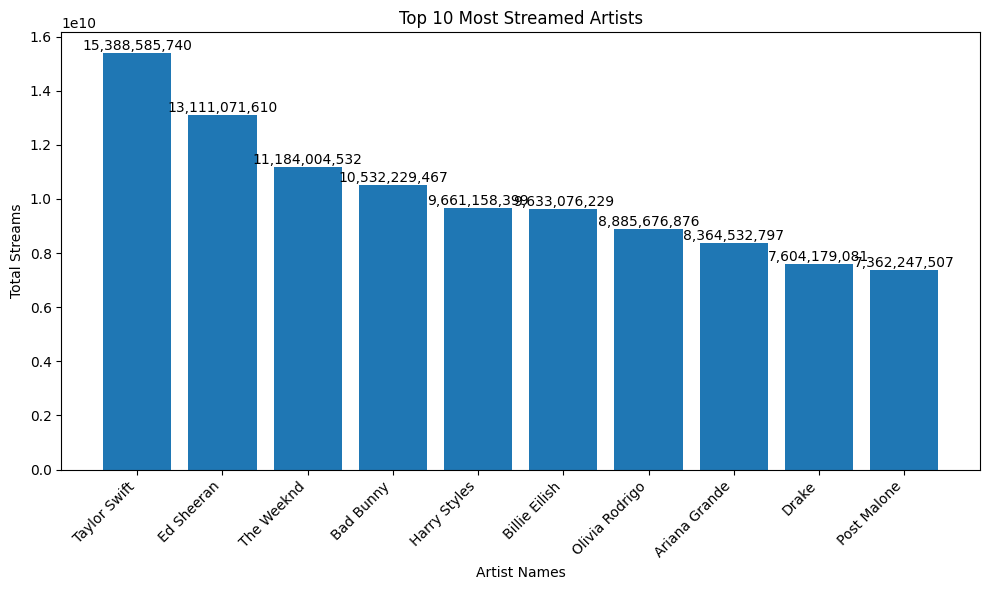

In [3]:
# Top 10 most streamed artists

artist_streams = spotify_df.groupby('artist_names')['streams'].sum().reset_index()
top_artists = artist_streams.sort_values(by='streams', ascending=False)
top_10_artists = top_artists.head(10)

print("Top 10 Most Streamed Artists:")
print(top_10_artists)

plt.figure(figsize=(10, 6))
bars = plt.bar(top_10_artists['artist_names'], top_10_artists['streams'])
plt.xlabel('Artist Names')
plt.ylabel('Total Streams')
plt.title('Top 10 Most Streamed Artists')
plt.xticks(rotation=45, ha='right')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1e6, f'{int(yval):,}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


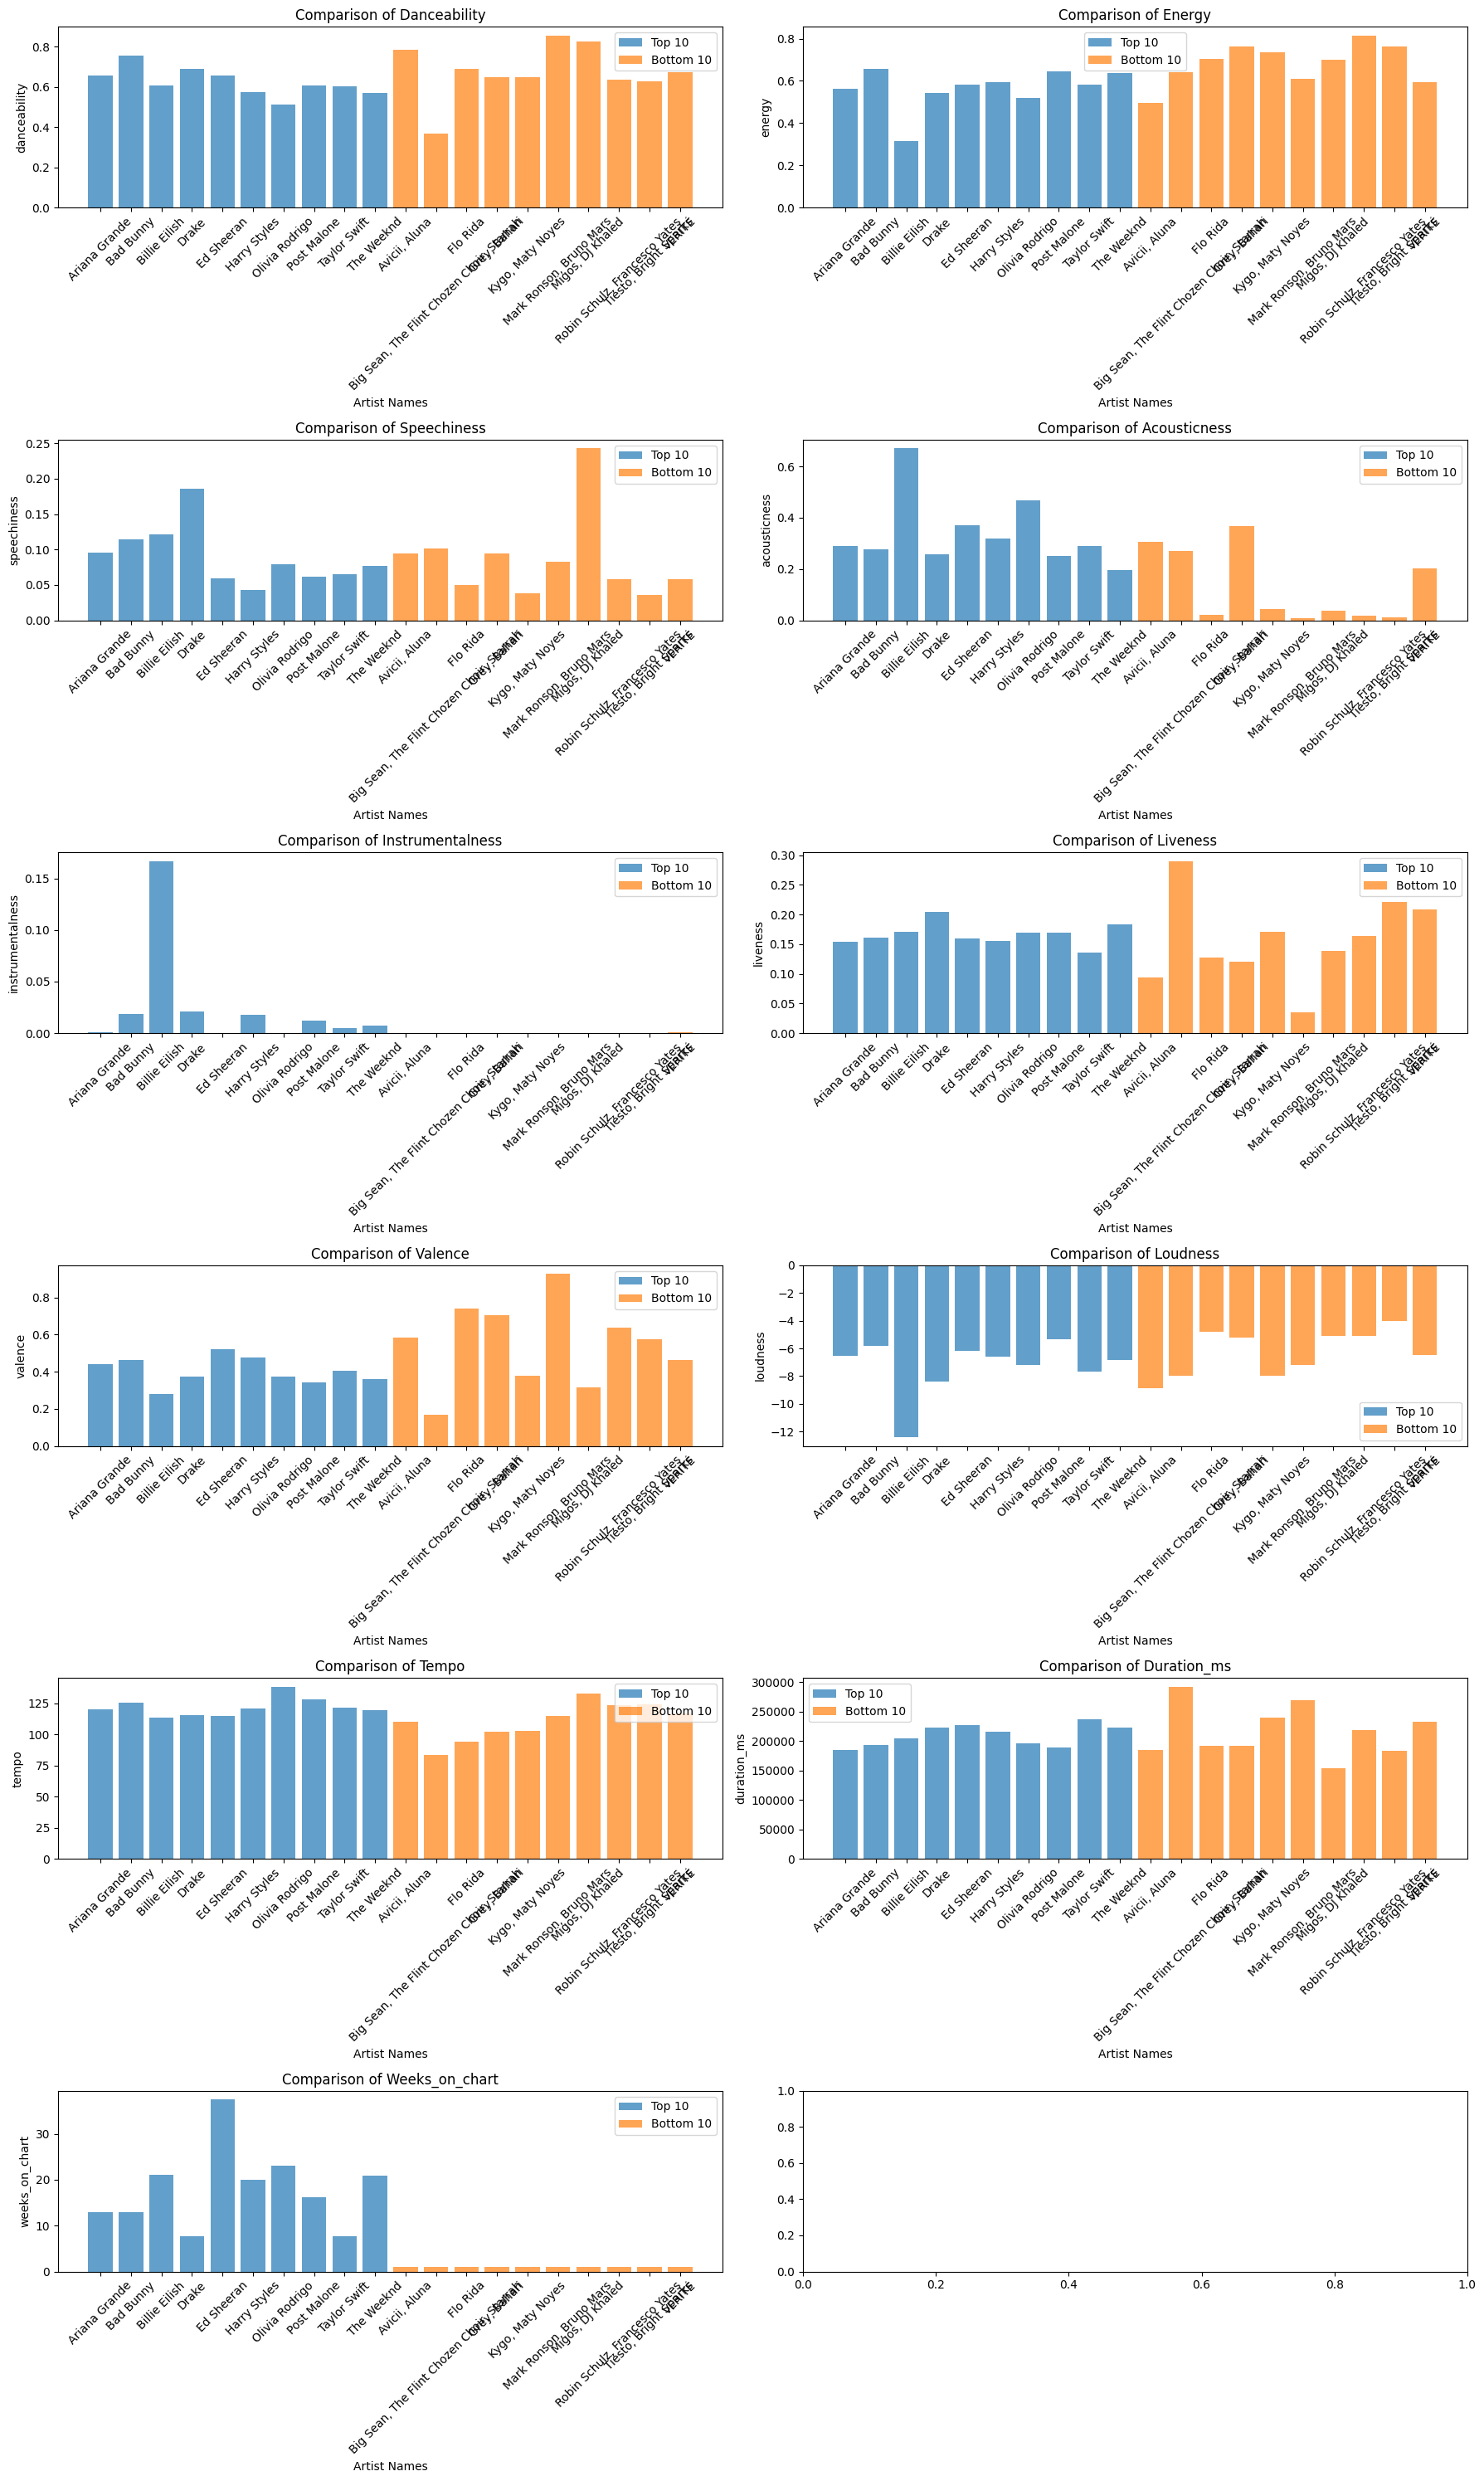

In [4]:
## Top 10 and bottom 10 streaming artists comparison in light of other features. Top performing songs have better instrumentality and accousticness.

artist_streams = spotify_df.groupby('artist_names')['streams'].sum().reset_index()
top_artists = artist_streams.sort_values(by='streams', ascending=False)
top_10_artists = top_artists.head(10)
bottom_10_artists = top_artists.tail(10)
top_10_artist_names = top_10_artists['artist_names'].tolist()
bottom_10_artist_names = bottom_10_artists['artist_names'].tolist()
top_10_artists_details = spotify_df[spotify_df['artist_names'].isin(top_10_artist_names)]
bottom_10_artists_details = spotify_df[spotify_df['artist_names'].isin(bottom_10_artist_names)]

numeric_features = ['danceability', 'energy', 'speechiness', 'acousticness',
                    'instrumentalness', 'liveness', 'valence', 'loudness',
                    'tempo', 'duration_ms', 'weeks_on_chart']

num_features = len(numeric_features)
num_rows = (num_features + 1) // 2

fig, axs = plt.subplots(num_rows, 2, figsize=(18, num_rows * 5))
axs = axs.flatten()

for i, feature in enumerate(numeric_features):
    top_means = top_10_artists_details.groupby('artist_names')[feature].mean().reset_index()
    bottom_means = bottom_10_artists_details.groupby('artist_names')[feature].mean().reset_index()

    axs[i].bar(top_means['artist_names'], top_means[feature], alpha=0.7, label='Top 10')
    axs[i].bar(bottom_means['artist_names'], bottom_means[feature], alpha=0.7, label='Bottom 10')

    axs[i].set_xlabel('Artist Names')
    axs[i].set_ylabel(feature)
    axs[i].set_title(f'Comparison of {feature.capitalize()}')
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].legend()

plt.tight_layout()
plt.show()

# One-Hot Encoding of Categorical Features

In [5]:
# the column time_signature is object dtype. converting all to str first then extracting the numeric part and convert it to int
spotify_df.rename(columns={'time_signature': 'time_signature_beats'}, inplace=True)
spotify_df['time_signature_beats'] = spotify_df['time_signature_beats'].astype(str)
spotify_df['time_signature_beats'] = spotify_df['time_signature_beats'].str.extract('(\d+)')
spotify_df['time_signature_beats'] = spotify_df['time_signature_beats'].astype(int)
print(spotify_df['time_signature_beats'])

# one-hot encoding key into columns of it's own but keeping the original key column for exploration, which won't be included when running a model.

if 'key_C' not in spotify_df.columns:
    key_dummies = pd.get_dummies(spotify_df['key'], prefix='key', dtype=int)
    spotify_df = pd.concat([spotify_df, key_dummies], axis=1)

spotify_df['mode'] = spotify_df['mode'].replace({'Major': 1, 'Minor': 0})

spotify_df.info()
spotify_df.head()


0       4
1       4
2       4
3       4
4       4
       ..
6508    4
6509    4
6510    4
6511    3
6512    4
Name: time_signature_beats, Length: 6513, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6513 entries, 0 to 6512
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    6513 non-null   object 
 1   artist_names          6513 non-null   object 
 2   track_name            6513 non-null   object 
 3   source                6513 non-null   object 
 4   key                   6513 non-null   object 
 5   mode                  6513 non-null   int64  
 6   time_signature_beats  6513 non-null   int64  
 7   danceability          6513 non-null   float64
 8   energy                6513 non-null   float64
 9   speechiness           6513 non-null   float64
 10  acousticness          6513 non-null   float64
 11  instrumentalness      6513 non-null   float64
 12  liveness 

,id,artist_names,track_name,source,key,mode,time_signature_beats,danceability,energy,speechiness,...,key_B,key_C,key_C#/Db,key_D,key_D#/Eb,key_E,key_F,key_F#/Gb,key_G,key_G#/Ab
0,000xQL6tZNLJzIrtIgxqSl,"ZAYN, PARTYNEXTDOOR",Still Got Time (feat. PARTYNEXTDOOR),RCA Records Label,G,1,4,0.748,0.627,0.0639,...,0,0,0,0,0,0,0,0,1,0
1,003eoIwxETJujVWmNFMoZy,Alessia Cara,Growing Pains,Def Jam Recordings,C#/Db,0,4,0.353,0.755,0.7330,...,0,0,1,0,0,0,0,0,0,0
2,003vvx7Niy0yvhvHt4a68B,The Killers,Mr. Brightside,Island Records,C#/Db,1,4,0.352,0.911,0.0747,...,0,0,1,0,0,0,0,0,0,0
3,00B7TZ0Xawar6NZ00JFomN,"Cardi B, Chance the Rapper",Best Life (feat. Chance The Rapper),Atlantic/KSR,A,1,4,0.620,0.625,0.5530,...,0,0,0,0,0,0,0,0,0,0
4,00Blm7zeNqgYLPtW6zg8cj,"Post Malone, The Weeknd",One Right Now (with The Weeknd),Republic Records,C#/Db,1,4,0.687,0.781,0.0530,...,0,0,1,0,0,0,0,0,0,0


# Initial Normality Visualization

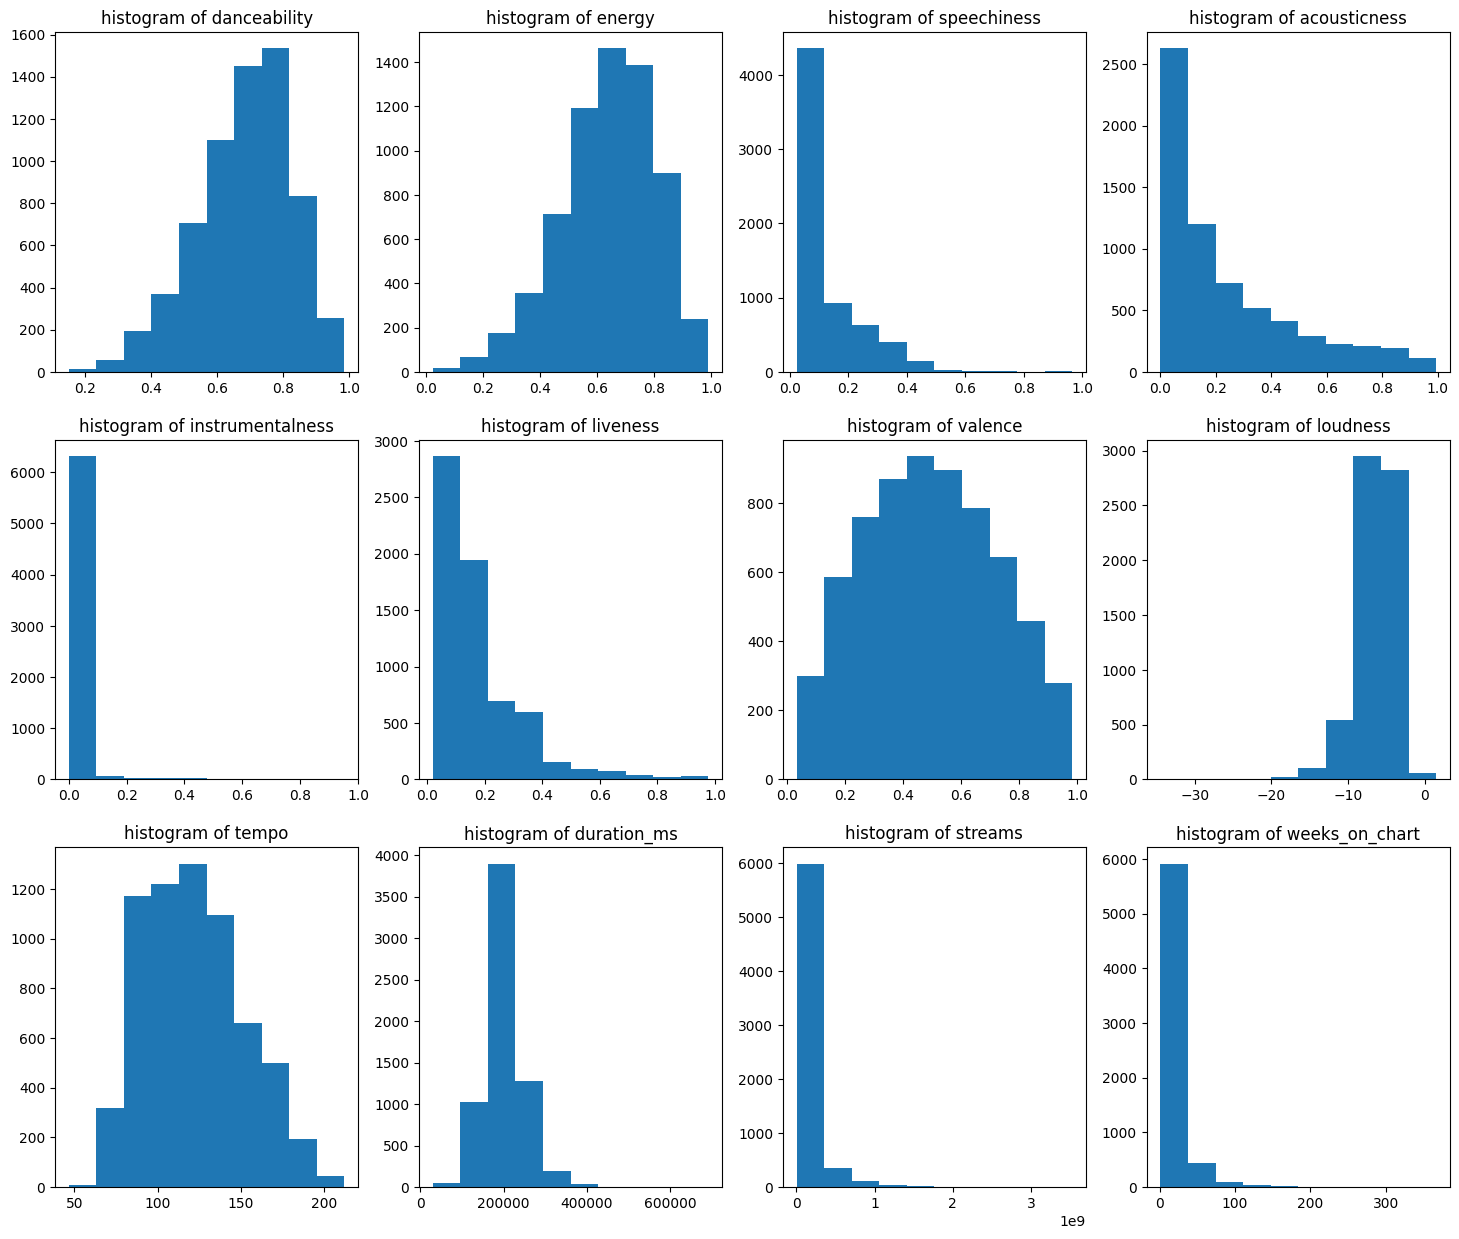

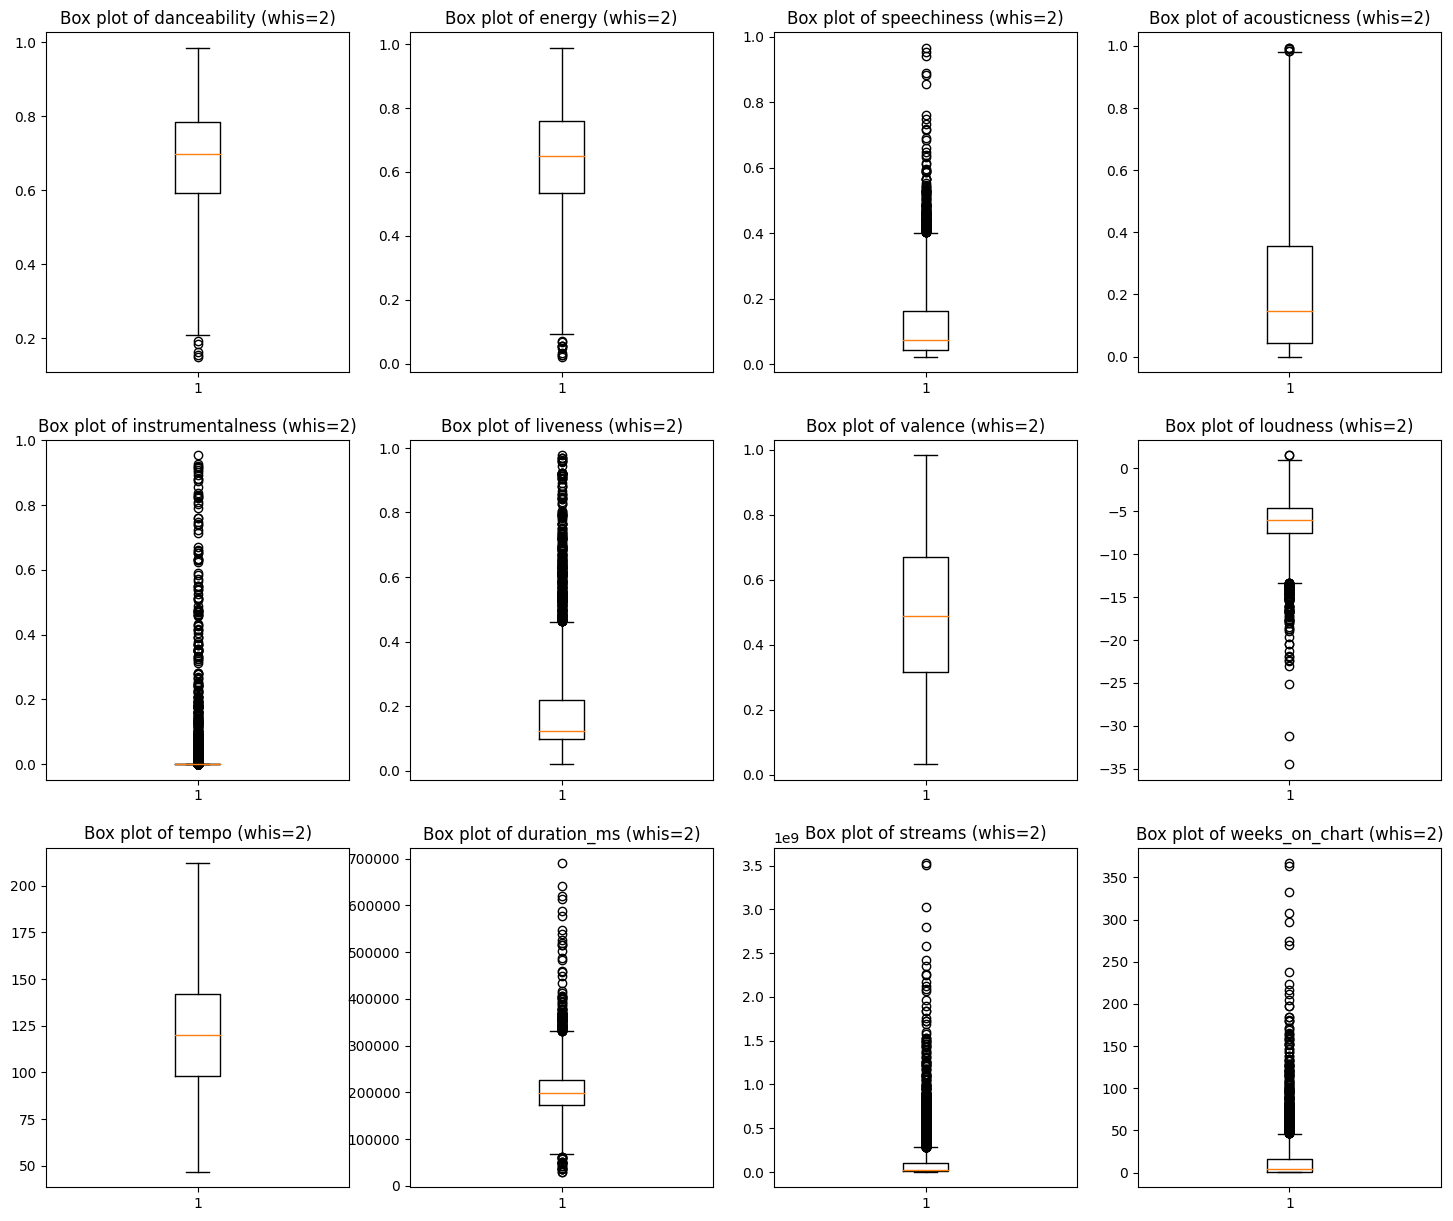

In [6]:
# visualizing all the continuous features for initial normality check

plt.figure(figsize=(18,15))

plt.subplot(3, 4, 1)
plt.hist(spotify_df["danceability"])
plt.title("histogram of danceability")

plt.subplot(3, 4, 2)
plt.hist(spotify_df["energy"])
plt.title("histogram of energy")

plt.subplot(3, 4, 3)
plt.hist(spotify_df["speechiness"])
plt.title("histogram of speechiness")

plt.subplot(3, 4, 4)
plt.hist(spotify_df["acousticness"])
plt.title("histogram of acousticness")

plt.subplot(3, 4, 5)
plt.hist(spotify_df["instrumentalness"])
plt.title("histogram of instrumentalness")

plt.subplot(3, 4, 6)
plt.hist(spotify_df["liveness"])
plt.title("histogram of liveness")

plt.subplot(3, 4, 7)
plt.hist(spotify_df["valence"])
plt.title("histogram of valence")

plt.subplot(3, 4, 8)
plt.hist(spotify_df["loudness"])
plt.title("histogram of loudness")

plt.subplot(3, 4, 9)
plt.hist(spotify_df["tempo"])
plt.title("histogram of tempo")

plt.subplot(3, 4, 10)
plt.hist(spotify_df["duration_ms"])
plt.title("histogram of duration_ms")

plt.subplot(3, 4, 11)
plt.hist(spotify_df["streams"])
plt.title("histogram of streams")

plt.subplot(3, 4, 12)
plt.hist(spotify_df["weeks_on_chart"])
plt.title("histogram of weeks_on_chart")

plt.show()


#  boxplots of features that look not normally distributed after initial visualization
#  streams, duration_ms, instrumentalness, liveness have very high variance in the interquartile range

plt.figure(figsize=(18,15))

# Histograms of the original data
plt.subplot(3, 4, 1)
plt.boxplot(spotify_df["danceability"], whis=2)
plt.title("Box plot of danceability (whis=2)")

plt.subplot(3, 4, 2)
plt.boxplot(spotify_df["energy"], whis=2)
plt.title("Box plot of energy (whis=2)")

plt.subplot(3, 4, 3)
plt.boxplot(spotify_df["speechiness"], whis=2)
plt.title("Box plot of speechiness (whis=2)")

plt.subplot(3, 4, 4)
plt.boxplot(spotify_df["acousticness"], whis=2)
plt.title("Box plot of acousticness (whis=2)")

plt.subplot(3, 4, 5)
plt.boxplot(spotify_df["instrumentalness"], whis=2)
plt.title("Box plot of instrumentalness (whis=2)")

plt.subplot(3, 4, 6)
plt.boxplot(spotify_df["liveness"], whis=2)
plt.title("Box plot of liveness (whis=2)")

plt.subplot(3, 4, 7)
plt.boxplot(spotify_df["valence"], whis=2)
plt.title("Box plot of valence (whis=2)")

plt.subplot(3, 4, 8)
plt.boxplot(spotify_df["loudness"], whis=2)
plt.title("Box plot of loudness (whis=2)")

plt.subplot(3, 4, 9)
plt.boxplot(spotify_df["tempo"], whis=2)
plt.title("Box plot of tempo (whis=2)")

plt.subplot(3, 4, 10)
plt.boxplot(spotify_df["duration_ms"], whis=2)
plt.title("Box plot of duration_ms (whis=2)")

plt.subplot(3, 4, 11)
plt.boxplot(spotify_df["streams"], whis=2)
plt.title("Box plot of streams (whis=2)")

plt.subplot(3, 4, 12)
plt.boxplot(spotify_df["weeks_on_chart"], whis=2)
plt.title("Box plot of weeks_on_chart (whis=2)")

plt.show()


# Zscore Normality Measure

In [7]:
#  applying zscore statistical measure to check for normality of the four features 'tempo', 'valence', 'danceability', 'energy'
#  that initially appeared to be close to normal distribution in the previous step.

from scipy.stats import zscore

z_scores = zscore(spotify_df[["tempo", "valence", "danceability", "energy"]])
for threshold in range(1,5):
    print("The score threshold is: {}".format(threshold))
    print("The indices of the outliers:")
    print(np.where(z_scores > threshold))
    print("Number of outliers is: {}".format(len((np.where(z_scores > threshold)[0]))))


The score threshold is: 1
The indices of the outliers:
(array([   1,    2,    3, ..., 6510, 6511, 6512]), array([0, 3, 0, ..., 2, 0, 0]))
Number of outliers is: 4366
The score threshold is: 2
The indices of the outliers:
(array([   1,   69,  143,  218,  253,  305,  345,  373,  405,  410,  487,
        492,  509,  600,  608,  616,  624,  635,  659,  669,  700,  707,
        714,  726,  746,  801,  824,  846,  892,  933,  949,  991,  995,
       1029, 1038, 1039, 1047, 1059, 1062, 1096, 1097, 1144, 1184, 1187,
       1229, 1236, 1264, 1377, 1394, 1408, 1419, 1470, 1473, 1487, 1584,
       1589, 1650, 1669, 1689, 1695, 1712, 1721, 1734, 1737, 1806, 1843,
       1870, 1916, 1926, 1926, 1930, 1933, 2007, 2015, 2031, 2031, 2054,
       2058, 2083, 2083, 2099, 2254, 2293, 2341, 2377, 2378, 2380, 2390,
       2425, 2477, 2506, 2533, 2613, 2614, 2622, 2670, 2732, 2812, 2821,
       2835, 2855, 2877, 2887, 2929, 2965, 3017, 3046, 3119, 3131, 3152,
       3159, 3187, 3194, 3209, 3218, 3271, 3425,

# Tukey's Method

In [8]:
#  Tukey's Method for identifying outliers with non-normally distributed features. Getting better insight into the features, such as 'acousticness'
#  shows quick normalization at threshold 2.5, while 'instrumentalness' consistently shows hight outliers. All the rest decrease proportionally as the threshold increases as expected.

features = ["speechiness", "acousticness", "instrumentalness", "liveness", "loudness", "duration_ms", "streams"]
outlier_counts = {feature: [] for feature in features}

for threshold in np.arange(1, 5, 0.5):
    print(f"The score threshold is: {threshold}")
    for feature in features:
        q75, q25 = np.percentile(spotify_df[feature], [75, 25])
        iqr = q75 - q25
        min_val = q25 - (iqr * threshold)
        max_val = q75 + (iqr * threshold)

        # Count outliers for the current feature and threshold
        outliers = spotify_df[(spotify_df[feature] > max_val) | (spotify_df[feature] < min_val)]
        outlier_count = len(outliers)
        outlier_counts[feature].append(outlier_count)

        print(f"Number of outliers in {feature} is: {outlier_count}")

The score threshold is: 1.0
Number of outliers in speechiness is: 749
Number of outliers in acousticness is: 575
Number of outliers in instrumentalness is: 1415
Number of outliers in liveness is: 738
Number of outliers in loudness is: 413
Number of outliers in duration_ms is: 508
Number of outliers in streams is: 1003
The score threshold is: 1.5
Number of outliers in speechiness is: 417
Number of outliers in acousticness is: 249
Number of outliers in instrumentalness is: 1340
Number of outliers in liveness is: 408
Number of outliers in loudness is: 205
Number of outliers in duration_ms is: 242
Number of outliers in streams is: 831
The score threshold is: 2.0
Number of outliers in speechiness is: 199
Number of outliers in acousticness is: 5
Number of outliers in instrumentalness is: 1297
Number of outliers in liveness is: 294
Number of outliers in loudness is: 113
Number of outliers in duration_ms is: 139
Number of outliers in streams is: 694
The score threshold is: 2.5
Number of outlie

# Winsorization and Min-Max Normalization of Features with Non-normal Distribution

In [9]:
from scipy.stats.mstats import winsorize

#####  winsorization
winsorize_top = ["streams", "duration_ms", "liveness", "instrumentalness", "speechiness", "acousticness"]
winsorize_bottom = ["loudness", "danceability", "energy"]

spotify_df_winsorized = spotify_df

#  apply one-way top winsorization for features with upper-end outliers
for feature in winsorize_top:
    spotify_df_winsorized[feature] = winsorize(spotify_df[feature], (0, 0.10))

#  apply one-way bottom winsorization for features with lower-end outliers
for feature in winsorize_bottom:
    spotify_df_winsorized[feature] = winsorize(spotify_df[feature], (0.10, 0))

##### normalization
from sklearn.preprocessing import MinMaxScaler

spotify_df_minmax = spotify_df_winsorized[["streams", "duration_ms", "liveness", "instrumentalness", "speechiness", "acousticness",
                                           "loudness", "danceability", "energy", "tempo", "valence"]]

scaler = MinMaxScaler()
spotify_df_minmax_normalized = scaler.fit_transform(spotify_df_minmax)
spotify_df_minmax_final = pd.DataFrame(spotify_df_minmax_normalized, columns=spotify_df_minmax.columns, index=spotify_df_minmax.index)

#  adding all of the rest of categorical features as a final step
categorical_features = ['weeks_on_chart', 'key_A', 'key_A#/Bb', 'key_B', 'key_C', 'key_C#/Db', 'key_D',
                        'key_D#/Eb', 'key_E', 'key_F', 'key_F#/Gb', 'key_G', 'key_G#/Ab']
spotify_df_minmax_final = pd.concat([spotify_df_minmax_final, spotify_df_winsorized[categorical_features]], axis=1)

spotify_df_minmax_final.head(20)


,streams,duration_ms,liveness,instrumentalness,speechiness,acousticness,loudness,danceability,energy,tempo,...,key_B,key_C,key_C#/Db,key_D,key_D#/Eb,key_E,key_F,key_F#/Gb,key_G,key_G#/Ab
0,0.359441,0.694105,0.197111,0.000000,0.148108,0.208922,0.306340,0.525050,0.370435,0.448884,...,0,0,0,0,0,0,0,0,1,0
1,0.025399,0.716849,1.000000,0.000000,1.000000,0.131090,0.283611,0.000000,0.593043,0.873252,...,0,0,1,0,0,0,0,0,0,0
2,1.000000,0.845245,0.240144,0.000000,0.187409,0.001918,0.379866,0.000000,0.864348,0.612549,...,0,0,1,0,0,0,0,0,0,0
3,0.032384,1.000000,0.885646,0.000000,1.000000,0.457729,0.176682,0.268537,0.366957,0.732731,...,0,0,0,0,0,0,0,0,0,0
4,1.000000,0.716091,0.167921,0.000000,0.108443,0.057564,0.418883,0.402806,0.638261,0.304089,...,0,0,1,0,0,0,0,0,0,0
5,0.327249,0.821926,0.217574,0.000000,0.233261,0.298237,0.470323,0.701403,0.669565,0.286066,...,0,0,0,0,0,0,0,0,1,0
6,0.007000,0.740203,0.271742,0.000514,0.454148,0.030291,0.332106,0.390782,0.624348,0.442826,...,0,0,0,0,0,0,1,0,0,0
7,0.086920,0.838955,0.247668,1.000000,1.000000,1.000000,0.425784,0.496994,0.000000,0.700161,...,0,0,0,0,0,0,0,0,1,0
8,0.008175,0.266837,0.401144,0.000000,0.545124,0.067931,0.099383,0.743487,0.253913,0.291604,...,0,0,0,0,0,0,0,0,0,1
9,0.011397,0.858560,0.383088,0.000000,0.211790,1.000000,0.039293,0.176353,0.000000,0.231301,...,0,0,1,0,0,0,0,0,0,0


# Normality Testing for All Continuous Features

In [10]:
#  Jarque-Bera and Normality tests suggest that all of the continuous features are still non-normally distributed after log-transformation and min-max normalization.
#  However, I will still use these features because they might still be useful.
from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(spotify_df_minmax_final["danceability"])
norm_stats = normaltest(spotify_df_minmax_final["danceability"])

print("Jarque-Bera test statistics for danceability is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics for danceability is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(spotify_df_minmax_final["energy"])
norm_stats = normaltest(spotify_df_minmax_final["energy"])

print("Jarque-Bera test statistics for energy is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics for energy is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(spotify_df_minmax_final["speechiness"])
norm_stats = normaltest(spotify_df_minmax_final["speechiness"])

print("Jarque-Bera test statistics for speechiness is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics for speechiness is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(spotify_df_minmax_final["acousticness"])
norm_stats = normaltest(spotify_df_minmax_final["acousticness"])

print("Jarque-Bera test statistics for acousticness is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics for acousticness is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(spotify_df_minmax_final["instrumentalness"])
norm_stats = normaltest(spotify_df_minmax_final["instrumentalness"])

print("Jarque-Bera test statistics for instrumentalness is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics for instrumentalness is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(spotify_df_minmax_final["liveness"])
norm_stats = normaltest(spotify_df_minmax_final["liveness"])

print("Jarque-Bera test statistics for liveness is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics for liveness is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(spotify_df_minmax_final["valence"])
norm_stats = normaltest(spotify_df_minmax_final["valence"])

print("Jarque-Bera test statistics for valence is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics for valence is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(spotify_df_minmax_final["loudness"])
norm_stats = normaltest(spotify_df_minmax_final["loudness"])

print("Jarque-Bera test statistics for loudness is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics for loudness is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(spotify_df_minmax_final["tempo"])
norm_stats = normaltest(spotify_df_minmax_final["tempo"])

print("Jarque-Bera test statistics for tempo is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics for tempo is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(spotify_df_minmax_final["duration_ms"])
norm_stats = normaltest(spotify_df_minmax_final["duration_ms"])

print("Jarque-Bera test statistics for duration_ms is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics for duration_ms is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(spotify_df_minmax_final["streams"])
norm_stats = normaltest(spotify_df_minmax_final["streams"])

print("Jarque-Bera test statistics for duration_ms is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics for duration_ms is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))


Jarque-Bera test statistics for danceability is 237.06385058231334 and p value is 3.328426083074104e-52
Normality test statistics for danceability is 1022.9383269264488 and p value is 7.44328493145775e-223
Jarque-Bera test statistics for energy is 241.67844300765978 and p value is 3.312782348141095e-53
Normality test statistics for energy is 1103.6865864453948 and p value is 2.175218449118362e-240
Jarque-Bera test statistics for speechiness is 1210.166372899858 and p value is 1.6432779672741076e-263
Normality test statistics for speechiness is 872.12471982521 and p value is 4.1737201327015565e-190
Jarque-Bera test statistics for acousticness is 850.3496965396561 and p value is 2.2331070999555368e-185
Normality test statistics for acousticness is 876.9082185870757 and p value is 3.8176821380877373e-191
Jarque-Bera test statistics for instrumentalness is 8706.573703037426 and p value is 0.0
Normality test statistics for instrumentalness is 2734.7522193506406 and p value is 0.0
Jarque-Ber

# Exploratory Analysis

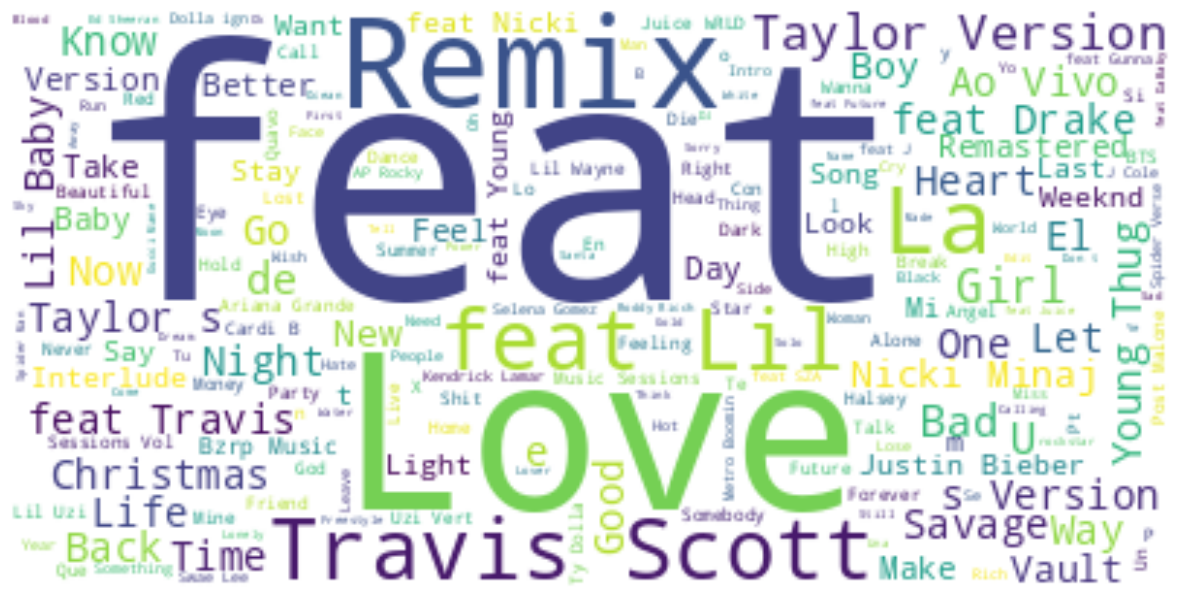

In [11]:
#  the word cloud of track_name reveals that songs that make it to the top list ara about love. Something to consider maybe for later

from wordcloud import WordCloud

wordcloud = WordCloud(background_color="white").generate(" ".join(spotify_df["track_name"]))
plt.figure(figsize=(15,10))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.show()

# Exploring Correlation Between Features

In [12]:
spotify_df_minmax_final.corr()

#  The correlation matrix suggests that there's a positive relationship between time signature and both danceability and energy, suggesting that tracks with a faster tempo
#     and more rhythm are generally more lively and suitable for dancing. There's also a correlation between energy and loudness,
#     implying that tracks with higher volume levels are typically more dynamic.
#  Acousticness has a negative relationship with energy, indicating that tracks with a higher acoustic presence are usually less vibrant.
#  The matrix also indicates that the musical key has little effect on these metrics.


,streams,duration_ms,liveness,instrumentalness,speechiness,acousticness,loudness,danceability,energy,tempo,...,key_B,key_C,key_C#/Db,key_D,key_D#/Eb,key_E,key_F,key_F#/Gb,key_G,key_G#/Ab
streams,1.000000,0.033347,-0.044971,-0.032167,-0.096391,-0.008751,0.063625,0.050375,0.020742,-0.010666,...,0.028599,-0.007488,-0.028153,0.009079,-0.008561,-0.003360,0.034402,0.012953,-0.016857,0.013636
duration_ms,0.033347,1.000000,0.000047,-0.033753,-0.065253,-0.056826,0.006589,-0.147082,0.027586,-0.014577,...,-0.025114,0.026056,0.006161,0.007771,-0.013324,-0.006081,-0.001931,0.011400,0.022295,0.000816
liveness,-0.044971,0.000047,1.000000,-0.035832,0.033651,-0.062030,0.056450,-0.087329,0.124465,-0.005535,...,-0.000343,-0.008546,-0.001611,0.004227,-0.003886,0.016633,0.010138,-0.007990,0.015973,-0.012068
instrumentalness,-0.032167,-0.033753,-0.035832,1.000000,-0.119744,0.057476,-0.189572,-0.023967,-0.062374,-0.022479,...,0.002539,0.024440,-0.007084,-0.018811,-0.024239,0.015033,0.003507,-0.005464,-0.008082,0.007112
speechiness,-0.096391,-0.065253,0.033651,-0.119744,1.000000,-0.090754,-0.045252,0.227972,-0.001339,0.130144,...,0.040594,-0.073818,0.090897,-0.002865,-0.032421,-0.046955,-0.048858,0.008895,-0.026843,0.018439
acousticness,-0.008751,-0.056826,-0.062030,0.057476,-0.090754,1.000000,-0.329620,-0.205145,-0.426522,-0.067404,...,-0.018796,0.036694,-0.085508,-0.000961,0.035271,0.031198,-0.008323,0.022821,-0.001389,-0.004915
loudness,0.063625,0.006589,0.056450,-0.189572,-0.045252,-0.329620,1.000000,0.127543,0.704038,0.055713,...,0.002835,-0.013440,0.026678,-0.017222,0.002410,0.015714,-0.004114,0.023408,-0.003127,-0.002627
danceability,0.050375,-0.147082,-0.087329,-0.023967,0.227972,-0.205145,0.127543,1.000000,0.057294,-0.065276,...,0.062252,-0.053067,0.055366,-0.011747,-0.037766,-0.022791,-0.004457,0.009332,-0.013758,0.009867
energy,0.020742,0.027586,0.124465,-0.062374,-0.001339,-0.426522,0.704038,0.057294,1.000000,0.088350,...,0.027288,-0.013493,0.011595,-0.005407,-0.023093,-0.001394,-0.009336,0.015831,0.007278,-0.015389
tempo,-0.010666,-0.014577,-0.005535,-0.022479,0.130144,-0.067404,0.055713,-0.065276,0.088350,1.000000,...,0.004987,-0.007330,0.037843,0.004753,-0.018876,-0.007389,-0.006931,-0.009740,-0.003745,-0.027248


# Bivariate Exploration

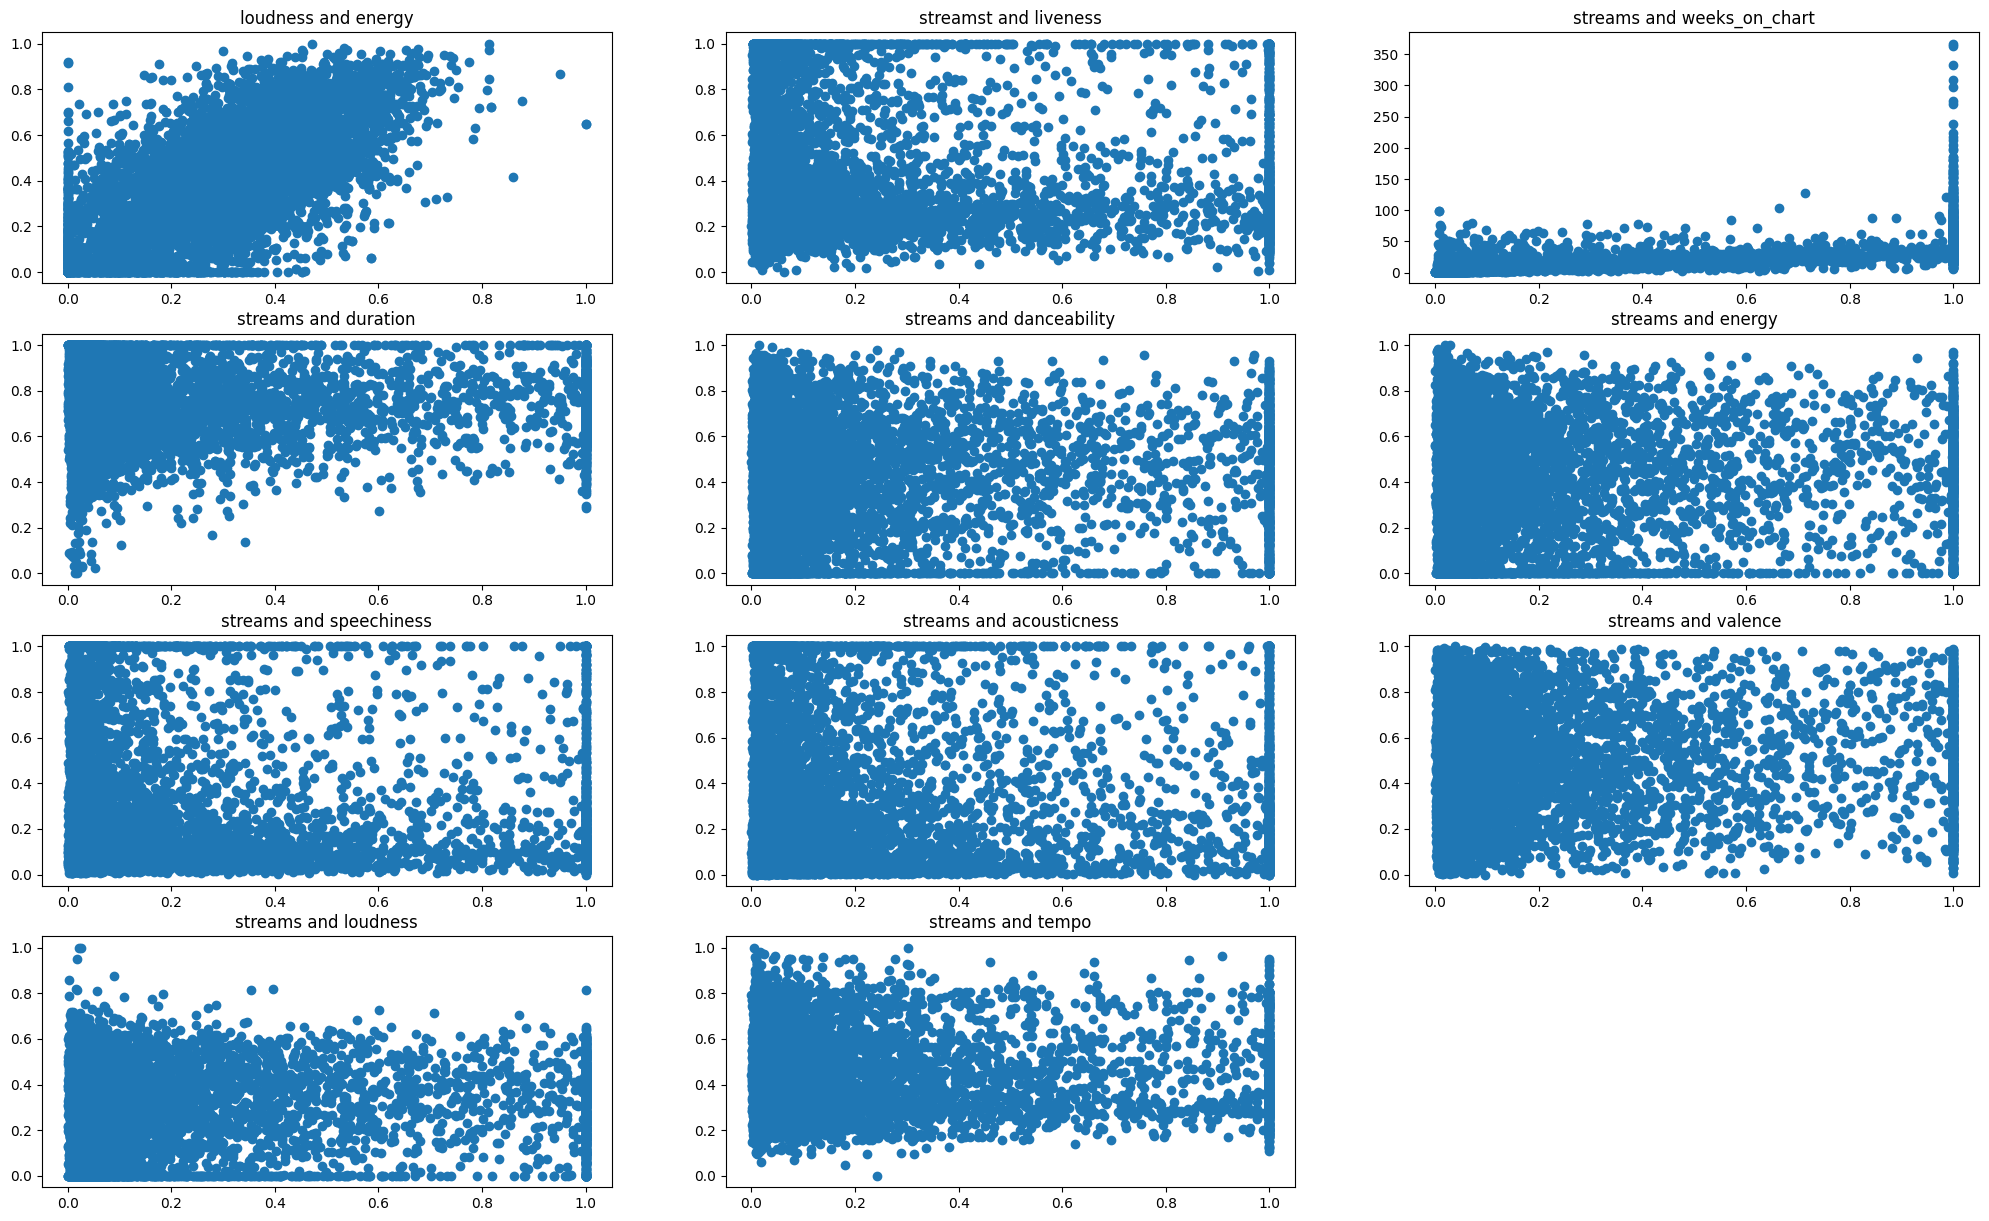

In [13]:
#  the bivariate examination of continuous features reveals that there is positive correlation between loudness and energy

plt.figure(figsize=(25,15))

plt.subplot(4,3,1)
plt.scatter(spotify_df_minmax_final["loudness"], spotify_df_minmax_final["energy"])
plt.title("loudness and energy")

plt.subplot(4,3,2)
plt.scatter(spotify_df_minmax_final["streams"], spotify_df_minmax_final["liveness"])
plt.title("streamst and liveness")

plt.subplot(4,3,3)
plt.scatter(spotify_df_minmax_final["streams"], spotify_df_minmax_final["weeks_on_chart"])
plt.title("streams and weeks_on_chart")

plt.subplot(4,3,4)
plt.scatter(spotify_df_minmax_final["streams"], spotify_df_minmax_final["duration_ms"])
plt.title("streams and duration")

plt.subplot(4,3,5)
plt.scatter(spotify_df_minmax_final["streams"], spotify_df_minmax_final["danceability"])
plt.title("streams and danceability")

plt.subplot(4,3,6)
plt.scatter(spotify_df_minmax_final["streams"], spotify_df_minmax_final["energy"])
plt.title("streams and energy")

plt.subplot(4,3,7)
plt.scatter(spotify_df_minmax_final["streams"], spotify_df_minmax_final["speechiness"])
plt.title("streams and speechiness")

plt.subplot(4,3,8)
plt.scatter(spotify_df_minmax_final["streams"], spotify_df_minmax_final["acousticness"])
plt.title("streams and acousticness")

plt.subplot(4,3,9)
plt.scatter(spotify_df_minmax_final["streams"], spotify_df_minmax_final["valence"])
plt.title("streams and valence")

plt.subplot(4,3,10)
plt.scatter(spotify_df_minmax_final["streams"], spotify_df_minmax_final["loudness"])
plt.title("streams and loudness")

plt.subplot(4,3,11)
plt.scatter(spotify_df_minmax_final["streams"], spotify_df_minmax_final["tempo"])
plt.title("streams and tempo")

plt.show()


# Exploring Categorical Features

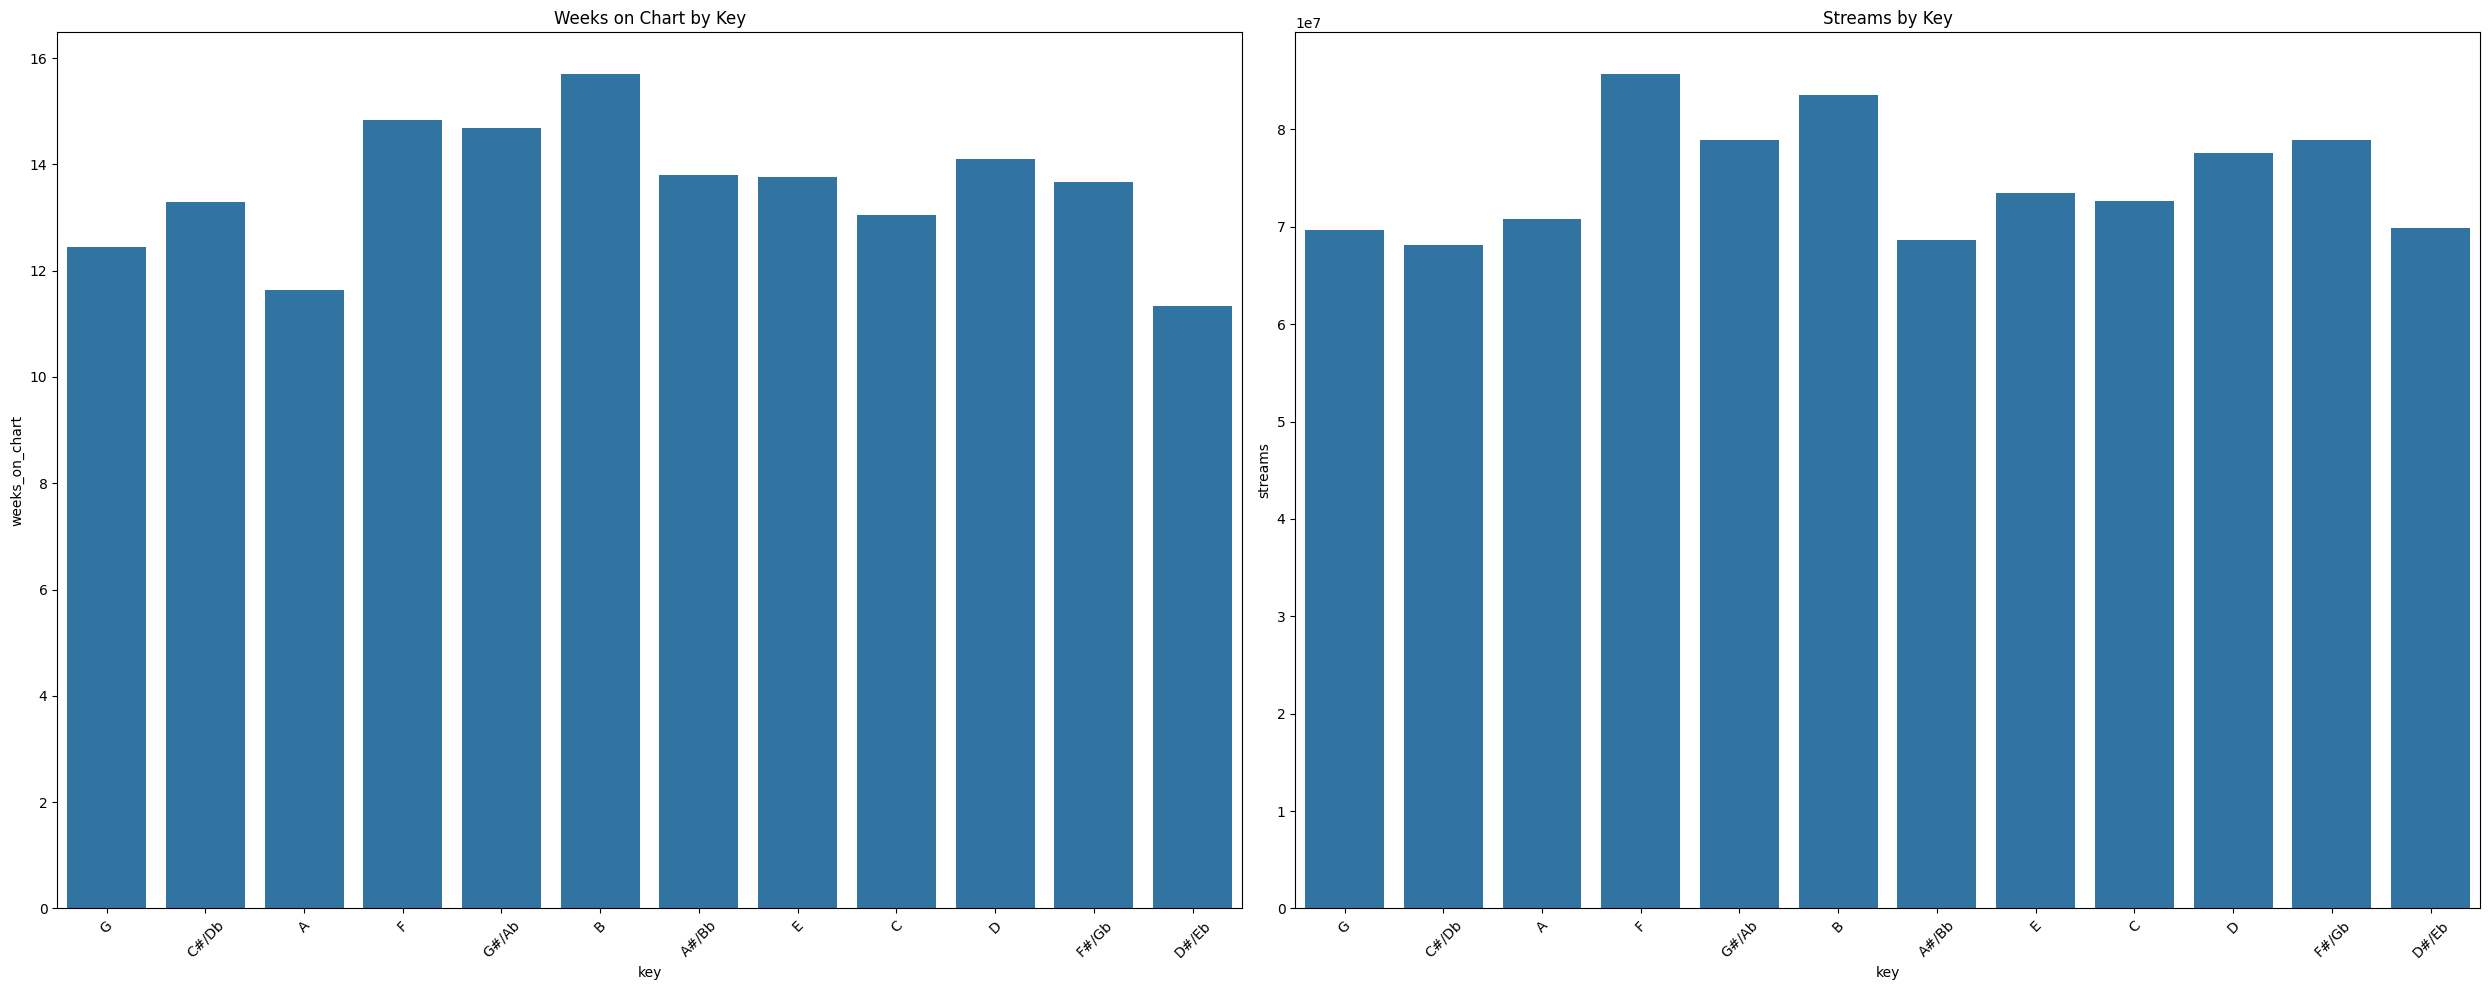

In [14]:
# Setting the overall figure size for the subplots
plt.figure(figsize=(25, 10))

# Subplot 1: Weeks on Chart by Key
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
sns.barplot(x=spotify_df["key"], y=spotify_df["weeks_on_chart"], ci=None)
plt.title("Weeks on Chart by Key")
plt.xticks(rotation=45)  # Optional: Rotate x labels for better visibility

# Subplot 2: Streams by Key
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
sns.barplot(x=spotify_df["key"], y=spotify_df["streams"], ci=None)
plt.title("Streams by Key")
plt.xticks(rotation=45)  # Optional: Rotate x labels for better visibility

# Show the plot
plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.show()

#  the chart on the left indicates that songs in the B key have slight advantage over other keys


# Bivariate Analysis of Categorical and Continuous Features

# PCA Covariance Matrix: Feature Selection

In [15]:
#  The first eigenvalue 'mode', 'time_signature_beats' and 'danceability' and other features' contributions to the first principal
#     component dominate the dataset's variance explanation.

import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sqlalchemy import create_engine
import warnings
warnings.filterwarnings('ignore')

#  selecting all numerical features and dropping target 'streams'
X = spotify_df_minmax_final.select_dtypes(include=[np.number])
X = X.drop('streams', axis=1)
X.info()


Xt = X.T
Cx = np.cov(Xt)
print('Covariance Matrix:\n', Cx)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6513 entries, 0 to 6512
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   duration_ms       6513 non-null   float64
 1   liveness          6513 non-null   float64
 2   instrumentalness  6513 non-null   float64
 3   speechiness       6513 non-null   float64
 4   acousticness      6513 non-null   float64
 5   loudness          6513 non-null   float64
 6   danceability      6513 non-null   float64
 7   energy            6513 non-null   float64
 8   tempo             6513 non-null   float64
 9   valence           6513 non-null   float64
 10  weeks_on_chart    6513 non-null   int64  
 11  key_A             6513 non-null   int64  
 12  key_A#/Bb         6513 non-null   int64  
 13  key_B             6513 non-null   int64  
 14  key_C             6513 non-null   int64  
 15  key_C#/Db         6513 non-null   int64  
 16  key_D             6513 non-null   int64  


# Calculating Eigenvectors and Eigenvalues: Feature Selection

Eigenvector 1: 
[-3.82694185e-04  5.30988046e-04  3.25796102e-04  1.15250517e-03
 -8.70098000e-05 -3.62171071e-04 -1.48213460e-04 -4.80380094e-05
  1.32897881e-04 -4.08714826e-04 -9.99998747e-01  2.73574820e-04
 -2.35721694e-05 -3.12793365e-04  1.07100649e-04  8.19160598e-05
 -6.64014640e-05  1.09846946e-04 -1.56982136e-05 -1.71712866e-04
 -7.92563478e-06  1.82929602e-04 -1.57264363e-04]
Eigenvalue 1: 580.0429507577593
----------------------------------------
Eigenvector 2: 
[-1.04648220e-02  8.84688491e-02 -2.25479186e-01  3.44140202e-01
 -5.91344733e-01  2.22695451e-01  2.54750151e-01  3.56501117e-01
  5.75790052e-02  2.00333625e-01  2.04150011e-04 -5.77111479e-02
  3.59195629e-03  3.70390614e-02 -1.69370611e-01  3.84826180e-01
 -2.49813619e-02 -1.98230100e-02 -5.14795608e-02 -3.26475708e-02
 -1.55513824e-02 -3.55741010e-02 -1.83184520e-02]
Eigenvalue 2: 0.16532913673853208
----------------------------------------
Eigenvector 3: 
[-2.32877168e-03 -9.07241430e-02  1.20737519e-01  1.38

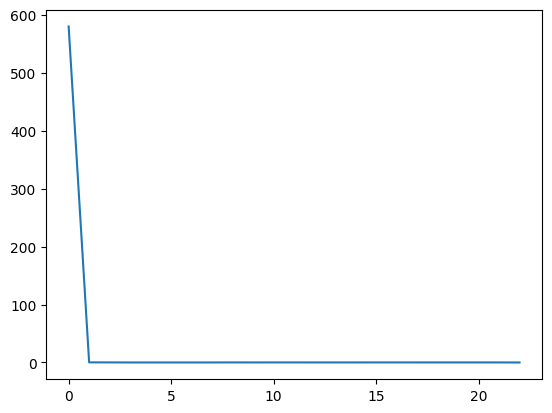

[5.80042951e+02 1.65329137e-01 1.34276963e-01 1.10122114e-02
 2.52363362e-02 2.60507004e-02 3.12393809e-02 2.96845996e-02
 1.15034623e-01 5.36236928e-02 1.02242479e-01 9.54054566e-02
 6.56189061e-02 6.97931980e-02 7.31807077e-02 8.89846909e-02
 8.61357967e-02 7.76304740e-02 8.30764521e-02 8.19796307e-02
 8.11335442e-02 8.05096516e-02 1.27670165e-16]


In [16]:
#  the scree plot reveals that only the first principal component captures a substantial portion of the total variance in the dataset.
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:, i].T
    print('Eigenvector {}: \n{}'.format(i + 1, eigvec_cov))
    print('Eigenvalue {}: {}'.format(i + 1, eig_val_cov[i]))
    print(40 * '-')

print(
    'The proportion of total variance in the dataset explained by each',
    'component calculated by hand\n',
    eig_val_cov / sum(eig_val_cov)
)

#  the scree plot
plt.plot(eig_val_cov)
plt.show()

print(eig_val_cov)

# Applying PCA to the Dataset

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.9972883]


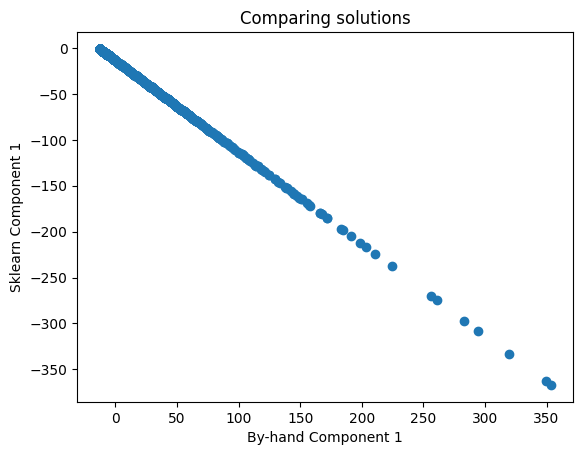

In [17]:
#  setting n_components to 1

sklearn_pca = PCA(n_components=1)
Y_sklearn = sklearn_pca.fit_transform(X)

P = eig_vec_cov[:, 0]

#  transform `X` into `Y`.
Y = P.T.dot(Xt)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

plt.plot(Y_sklearn[:, 0], Y, 'o')
plt.title('Comparing solutions')
plt.ylabel('Sklearn Component 1')
plt.xlabel('By-hand Component 1')
plt.show()

# Linear Regression OLS Model

In [18]:
#  running the linear regression model

Y = spotify_df_minmax_final['streams']
X = Y_sklearn
X = sm.add_constant(X)

#  splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

#  fitting the model
results = sm.OLS(y_train, X_train).fit()
results.summary()

### Interpreting Results:
# R-squared of 0.353: This indicates that the model explains approximately 35.3% of the variance in the target variable, streams.
#     It suggests a moderate level of explanatory power, showing that while there is some relationship between the predictor(s)
#     and streams, a significant portion of the variance remains unexplained.
# Adj. R-squared of 0.352: Very close to the R-squared value, confirming the model's explanatory power without being overly optimistic due to the number of predictors.
# F-statistic (2836) with a Prob(F-statistic) of nearly 0.00: Demonstrates that the model is statistically significant.
#     This means the predictor(s) have a significant linear relationship with the target variable.
# Intercept (const) of 17.2345: Indicates the expected value of streams (in its log-transformed scale) when all predictors are 0.
#     It's highly significant, as shown by the t-statistic and P-value.
# Durbin-Watson statistic of 1.945: Suggests that there is minimal autocorrelation in the residuals, which is desirable for OLS regression models.
# Normality Tests (Omnibus, Jarque-Bera): Indicate significant deviations from normality in the residuals, suggesting that the error terms do not
#     follow a normal distribution. This might affect the reliability of some statistical tests.
# Skewness and Kurtosis: Point to the presence of skewness and heavier tails in the distribution of residuals than would be expected in a normal distribution.

### CONCLUSION: the linear regression model reveals a significant relationship between predictors and the target variable, with some limitations in model fit and assumptions.


The number of observations in training set is 5210
The number of observations in test set is 1303


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                streams   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     5129.
Date:                Tue, 11 Jun 2024   Prob (F-statistic):               0.00
Time:                        00:18:05   Log-Likelihood:                 235.30
No. Observations:                5210   AIC:                            -466.6
Df Residuals:                    5208   BIC:                            -453.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2459      0.003     76.719      0.000       0.240       0.252
x1             0.0094      0.000     71.618      0.000       0.009       0.010
==============================================================================
Omnibus:                      888.830   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19266.623
Skew:                           0.062   Prob(JB):                         0.00
Kurtosis:                      12.420   Cond. No.                         24.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Prediction

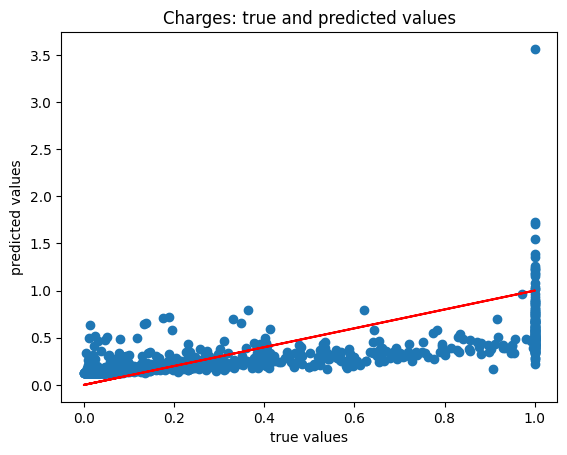

Mean absolute error of the prediction is: 0.15640062843467542
Mean squared error of the prediction is: 0.05006619784147991
Root mean squared error of the prediction is: 0.22375477166192437
Mean absolute percentage error of the prediction is: inf


In [19]:
# Add a constant to the model because it's best practice to do so every time!
X_test = sm.add_constant(X_test)

# You are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test))))


### Prediction Results:
# With MAE of 0.9042, MSE of 1.1717, RMSE of 1.0825 and MAPE of 5.25% the model shows a relatively low error in both absolute terms (MAE, RMSE)
#     and relative terms (MAPE), indicating good predictive performance.

# Gradient Boosting Regressor Model

In [22]:
# Configuration for Gradient Boosting Regressor
params = {
    'n_estimators': 500,
    'max_depth': 4,
    'min_samples_split': 2,
    'learning_rate': 0.01,
    'loss': 'squared_error'
}

boost = spotify_df_minmax_final.select_dtypes(include=[np.number])

Xb = boost.drop('streams', axis=1)
Yb = boost['streams']

#  splitting data into train and test sets
X_tr, X_te, y_tr, y_te = train_test_split(Xb, Yb, test_size = 0.2, random_state = 465)

# Initialize and fit the model
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_tr, y_tr)

# Make predictions
predictions_tr = reg.predict(X_tr)
predictions_te = reg.predict(X_te)

# Evaluate the model
mse_train = mean_squared_error(y_tr, predictions_tr)
mse_test = mean_squared_error(y_te, predictions_te)
r2_train = r2_score(y_tr, predictions_tr)
r2_test = r2_score(y_te, predictions_te)
mae_train = mean_absolute_error(y_tr, predictions_tr)
mae_test = mean_absolute_error(y_te, predictions_te)

# Display Metrics
print(f"Training Metrics:\nR-squared: {r2_train:.3f}\nMSE: {mse_train:.3f}\nMAE: {mae_train:.3f}")
print(f"Testing Metrics:\nR-squared: {r2_test:.3f}\nMSE: {mse_test:.3f}\nMAE: {mae_test:.3f}")

#  with the baseline model at 1.9, MSE for this setting shows a good result.


Training Metrics:
R-squared: 0.808
MSE: 0.020
MAE: 0.080
Testing Metrics:
R-squared: 0.764
MSE: 0.025
MAE: 0.089


# The Baseline Model for Comparison

In [23]:
#  creating the baseline model using mean prediction of the target for all observations. This will help to understand how my model performs when comparint.

# Calculate the mean of the target variable
mean_target = np.mean(y_tr)

# Create an array filled with the mean value that matches the length of y_test
mean_predictions = np.full(shape=y_test.shape, fill_value=mean_target)

# Calculate the MSE for the baseline model
baseline_mse = mean_squared_error(y_test, mean_predictions)
print(f"Baseline Model MSE (Mean Predictor): {baseline_mse:.4f}")


Baseline Model MSE (Mean Predictor): 0.1063


# Grid Search for Optimal Hyperparameters

In [29]:
# #  I tried running the Gradient Boost Regressor using both PCA reduced features and original optimized feature sets and the second one performed uch better in trainig
# #  the train and test are close, whcih means the model generalizes well.
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import GradientBoostingRegressor

# reg = GradientBoostingRegressor()

# param_grid = {
#     'n_estimators': [100, 500, 1000],
#     'max_depth': [3, 4, 5],
#     'min_samples_split': [2, 4, 6],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'subsample': [0.5, 0.7, 1.0]
# }

# grid_search = GridSearchCV(estimator=reg, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
# grid_search.fit(X_tr, y_tr)

# print("Best parameters found: ", grid_search.best_params_)
# print("Lowest RMSE found: ", np.sqrt(np.abs(grid_search.best_score_)))


# Re-runing With Optimized Parameters

In [25]:
#  I am going to leave it like this because test and train are the closest here.

params = {
    'n_estimators': 700,
    'max_depth': 3,
    'min_samples_split': 4,
    'learning_rate': 0.01,
    'loss': 'squared_error'
}

boost = spotify_df_minmax_final.select_dtypes(include=[np.number])

Xb = boost.drop('streams', axis=1)
Yb = boost['streams']

X_tr, X_te, y_tr, y_te = train_test_split(Xb, Yb, test_size = 0.2, random_state = 465)

reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_tr, y_tr)

predictions_tr = reg.predict(X_tr)
predictions_te = reg.predict(X_te)

# Evaluate the model
mse_train = mean_squared_error(y_tr, predictions_tr)
mse_test = mean_squared_error(y_te, predictions_te)
r2_train = r2_score(y_tr, predictions_tr)
r2_test = r2_score(y_te, predictions_te)
mae_train = mean_absolute_error(y_tr, predictions_tr)
mae_test = mean_absolute_error(y_te, predictions_te)

# Display Metrics
print(f"Training Metrics:\nR-squared: {r2_train:.3f}\nMSE: {mse_train:.3f}\nMAE: {mae_train:.3f}")
print(f"Testing Metrics:\nR-squared: {r2_test:.3f}\nMSE: {mse_test:.3f}\nMAE: {mae_test:.3f}")

Training Metrics:
R-squared: 0.789
MSE: 0.022
MAE: 0.083
Testing Metrics:
R-squared: 0.775
MSE: 0.024
MAE: 0.088


In [26]:
#####   CONCLUSION
# R-SQUARED - The Gradient Boosting Regressor has a significantly higher R-squared value in both training and testing, indicating that it explains a higher proportion
#             of the variance in the target variable (streams) compared to the OLS Linear Regression.
# MSE - The Gradient Boosting Regressor has a much lower MSE, indicating better predictive accuracy and lower average squared errors in predictions.
# MAE - The Gradient Boosting Regressor also has lower MAE values, indicating more accurate predictions on average.
# Complexity and Overfitting - Gradient Boosting Regressor shows strong performance with close training and testing R-squared values, suggesting
#                              a well-generalized model.
# The Gradient Boosting Regressor significantly outperforms the OLS Linear Regression in terms of R-squared, MSE, and MAE for both training and testing
# datasets.


# Visualization

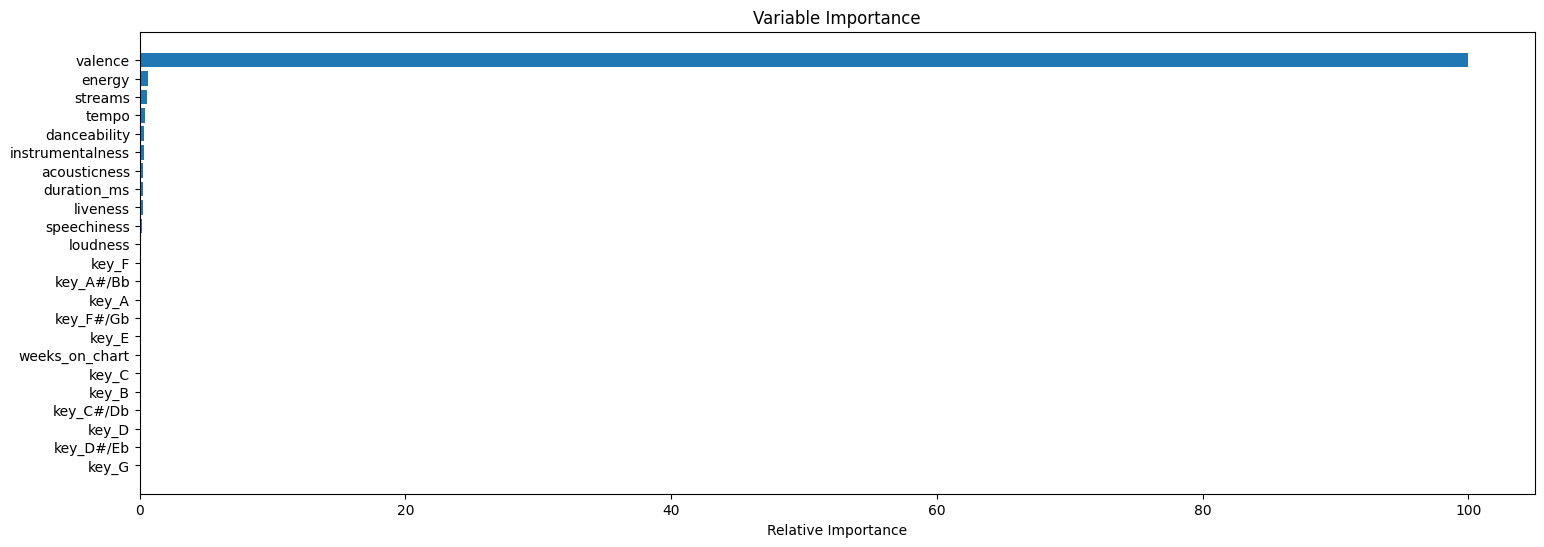

In [27]:
feature_importance = reg.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(18, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, boost.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()